In [ ]:
!pip install transformers
!pip install huggingface_hub
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 35.3 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
!pip install spacy
!python -m spacy download fr_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 13.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Personal Transformer
import spacy
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
import torch
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
raw_datasets = load_dataset("ashwinradhe/dl_dataset")
small_train_dataset = raw_datasets['train'].select(range(1000000))
SRC_LANGUAGE = "en"
TRG_LANGUAGE = "fr"
tokenizer_en = get_tokenizer('spacy', language='en_core_web_sm')
tokenizer_fr= get_tokenizer('spacy', language='fr_core_news_sm')
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']
def tokenize_and_build_vocab(data, tokenizer):
    tokenized_data = [tokenizer(sentence) for sentence in data]
    vocab = build_vocab_from_iterator(tokenized_data,min_freq=1, specials=special_symbols,special_first=True)
    vocab.set_default_index(vocab['<unk>'])
    return vocab, tokenized_data
vocab_en, tokenized_data_en = tokenize_and_build_vocab(small_train_dataset['English Sentence'], tokenizer_en)
vocab_fr, tokenized_data_fr = tokenize_and_build_vocab(small_train_dataset['French Sentence'], tokenizer_fr)
def numericalize_and_pad(tokenized_data, vocab):
    numericalized_data = [torch.tensor(vocab.lookup_indices(sentence)) for sentence in tokenized_data]
    padded_data = pad_sequence(numericalized_data, batch_first=True, padding_value=vocab['<pad>'])
    return padded_data
padded_data_en = numericalize_and_pad(tokenized_data_en, vocab_en)
padded_data_fr = numericalize_and_pad(tokenized_data_fr, vocab_fr)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1825077 [00:00<?, ? examples/s]

In [ ]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader
dataset = torch.utils.data.TensorDataset(padded_data_en, padded_data_fr)
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [ ]:
import torch
from torch import nn, Tensor
import math

class PositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(-torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size: int):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

class TransformerModel(nn.Module):
    def __init__(self, num_tokens_en, num_tokens_fr, embed_size, nhead, dim_feedforward, max_seq_length):
        super(TransformerModel, self).__init__()
        self.embed_size = embed_size
        self.src_tok_emb = TokenEmbedding(num_tokens_en, embed_size)
        self.tgt_tok_emb = TokenEmbedding(num_tokens_fr, embed_size)
        self.positional_encoding = PositionalEncoding(embed_size, dropout=0.1, maxlen=max_seq_length)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)

        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=0.1)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=3)
        self.generator = nn.Linear(embed_size, num_tokens_fr)

    def encode(self, src, src_mask):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        return self.transformer_encoder(src_emb, src_key_padding_mask=src_mask)

    def decode(self, tgt, memory, tgt_mask, tgt_key_padding_mask):
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(tgt))
        return self.transformer_decoder(tgt_emb, memory, tgt_mask, tgt_key_padding_mask=tgt_key_padding_mask)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, src_padding_mask=None, tgt_padding_mask=None):
        memory = self.encode(src, src_padding_mask)
        output = self.decode(tgt, memory, tgt_mask, tgt_padding_mask)
        return self.generator(output)

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz, device=device)).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
model_adamw_c = TransformerModel(len(vocab_en), len(vocab_fr), embed_size=64, nhead=8, dim_feedforward=1024, max_seq_length=512)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
optimizer = torch.optim.AdamW(model_adamw_c.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)
seq2seq_loss_adamw_c = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_adamw_c.to(device)
def train_and_evaluate(model, train_dataloader, val_dataloader, test_dataloader, optimizer, loss_function, vocab_en, vocab_fr, epochs=10):
    model.apply(init_weights)
    training_loss = []
    validation_loss = []
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for src, tgt in train_dataloader:
            src, tgt = src.to(device), tgt.to(device)
            src = src.T
            tgt_inp = tgt.T
            tgt_input = tgt_inp[:-1, :]
            tgt_output = tgt_inp[1:, :]
            src_seq_length = src.shape[0]
            tgt_seq_length = tgt_input.shape[0]
            src_mask = torch.zeros(src_seq_length, src_seq_length).to(device).type(torch.bool)
            tgt_mask = model.generate_square_subsequent_mask(tgt_seq_length).to(device)

            src_padding_mask = (src == PAD_IDX).transpose(0, 1).to(device)
            tgt_padding_mask = (tgt_input == PAD_IDX).transpose(0, 1).to(device)

            logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)
            logits = logits.view(-1, logits.shape[-1])
            tgt_output = tgt_output.reshape(-1)
            loss = seq2seq_loss_adamw_c(logits, tgt_output)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_train_loss += loss.item() if not torch.isnan(loss) else 0


        avg_train_loss = total_train_loss / len(train_dataloader)
        training_loss.append(avg_train_loss)
        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for src, tgt in val_dataloader:
                src, tgt = src.to(device), tgt.to(device)
                src = src.T
                tgt_inp = tgt.T
                tgt_input = tgt_inp[:-1, :]
                tgt_output = tgt_inp[1:, :]
                src_seq_length = src.shape[0]
                tgt_seq_length = tgt_input.shape[0]
                src_mask = torch.zeros(src_seq_length, src_seq_length).to(device).type(torch.bool)
                tgt_mask = model.generate_square_subsequent_mask(tgt_seq_length).to(device)
                src_padding_mask = (src == PAD_IDX).transpose(0, 1).to(device)
                tgt_padding_mask = (tgt_input == PAD_IDX).transpose(0, 1).to(device)
                logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)
                logits = logits.view(-1, logits.shape[-1])
                tgt_output = tgt_output.reshape(-1)
                loss = seq2seq_loss_adamw_c(logits, tgt_output)
                total_val_loss += loss.item()


        avg_val_loss = total_val_loss / len(val_dataloader)
        validation_loss.append(avg_val_loss)
        print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    return training_loss, validation_loss,model
training_loss_adamw_c, validation_loss_adamw_c,model_adamw_c = train_and_evaluate(model_adamw_c, train_dataloader, val_dataloader, test_dataloader, optimizer, vocab_en, vocab_fr, seq2seq_loss_adamw_c, epochs=10)

Epoch 1, Training Loss: 8.4689, Validation Loss: 8.3698
Epoch 2, Training Loss: 8.1995, Validation Loss: 8.2538
Epoch 3, Training Loss: 8.1047, Validation Loss: 8.0755
Epoch 4, Training Loss: 8.0093, Validation Loss: 8.0134
Epoch 5, Training Loss: 7.9248, Validation Loss: 7.8740
Epoch 6, Training Loss: 7.8514, Validation Loss: 7.8114
Epoch 7, Training Loss: 7.7954, Validation Loss: 7.7527
Epoch 8, Training Loss: 7.7564, Validation Loss: 7.7044
Epoch 9, Training Loss: 7.7275, Validation Loss: 7.6308
Epoch 10, Training Loss: 7.7065, Validation Loss: 7.6558


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


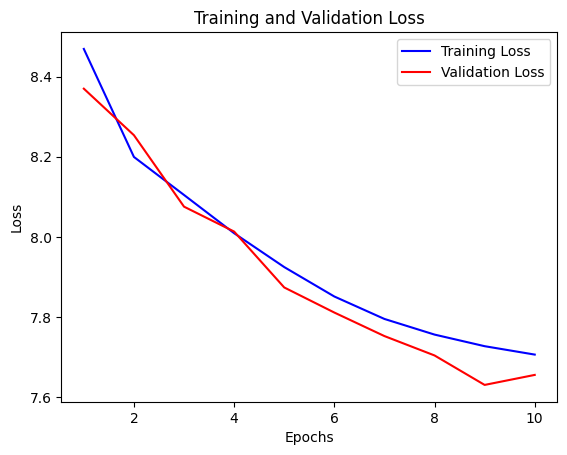

In [ ]:
import matplotlib.pyplot as plt
epochs = range(1, len(training_loss_adamw_c) + 1)
plt.plot(epochs, training_loss_adamw_c, 'b', label='Training Loss')
plt.plot(epochs, validation_loss_adamw_c, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model_metrcis_adamw_c = {'training_loss': training_loss_adamw_c, 'validation_loss': validation_loss_adamw_c}
torch.save(model_metrcis_adamw_c, '/content/drive/MyDrive/absolute_positional_encoding/model_metrics_adamw_c.pkl')

In [ ]:
torch.save(model_adamw_c.state_dict(), '/content/drive/MyDrive/absolute_positional_encoding/model_state_adamw_c.pkl')
torch.save(model_adamw_c, '/content/drive/MyDrive/absolute_positional_encoding/model_adamw_c.pt')